<a href="https://colab.research.google.com/github/aashay717/Regularising/blob/main/regularization_symmetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install svgwrite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.3 MB/s eta 0:00:00


REGULARIZATION OF DOODLES



In [16]:
import os
import numpy as np
import svgwrite
import cairosvg
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from scipy.special import comb
import zipfile

# Paths
zip_path = '/content/drive/MyDrive/adobezip.zip'
extracted_path = '/mnt/data/extracted'
input_file_path = '/mnt/data/extracted/problems/frag2.csv'
output_folder = '/mnt/data/extracted/output'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)



def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def bezier_curve(points, num=100):
    """Generate a Bézier curve from a list of points."""
    def bernstein_poly(i, n, t):
        return comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

    n = len(points) - 1
    curve = []
    for t in np.linspace(0, 1, num=num):
        x = sum(bernstein_poly(i, n, t) * points[i][0] for i in range(n + 1))
        y = sum(bernstein_poly(i, n, t) * points[i][1] for i in range(n + 1))
        curve.append([x, y])
    return np.array(curve)

def regularize_path(XY, window_size=11, polyorder=2):
    """Regularize a single path using Bézier curves and Savitzky-Golay filter."""
    if len(XY) < window_size:  # Skip smoothing if not enough points
        return XY

    smoothed_X = savgol_filter(XY[:, 0], window_length=window_size, polyorder=polyorder)
    smoothed_Y = savgol_filter(XY[:, 1], window_length=window_size, polyorder=polyorder)

    smoothed_path = np.vstack((smoothed_X, smoothed_Y)).T

    # Use Bézier curves for straight lines
    if np.allclose(smoothed_path[0], smoothed_path[-1]):
        # Closed shape
        return bezier_curve(smoothed_path)
    else:
        return smoothed_path

def regularize_paths(paths_XYs):
    regularized_paths = []
    for XYs in paths_XYs:
        reg_XYs = []
        for XY in XYs:
            reg_XY = regularize_path(XY)
            reg_XYs.append(reg_XY)
        regularized_paths.append(reg_XYs)
    return regularized_paths

def save_paths_to_csv(paths_XYs, csv_path):
    with open(csv_path, 'w') as f:
        for path_XYs in paths_XYs:
            for XY in path_XYs:
                np.savetxt(f, XY, delimiter=',', header='x,y', comments='', fmt='%.4f')
                f.write('\n')
            f.write('\n')

def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)

    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')

    for path_XYs in paths_XYs:
        for XY in path_XYs:
            path_data = ['M {:.4f} {:.4f}'.format(XY[0, 0], XY[0, 1])]
            for i in range(1, len(XY)):
                path_data.append('L {:.4f} {:.4f}'.format(XY[i, 0], XY[i, 1]))
            if np.allclose(XY[0], XY[-1]):  # Close the path if it's a closed shape
                path_data.append('Z')
            dwg.add(dwg.path(d=' '.join(path_data), fill='none', stroke='black', stroke_width=2))

    dwg.save()

    png_path = svg_path.replace('.svg', '.png')
    cairosvg.svg2png(url=svg_path, write_to=png_path, parent_width=W, parent_height=H,
                     output_width=W, output_height=H, background_color='white')

    return png_path

def main(input_file_path, output_folder):
    input_paths = read_csv(input_file_path)
    regularized_paths = regularize_paths(input_paths)
    output_csv_path = os.path.join(output_folder, 'regularized_paths.csv')
    save_paths_to_csv(regularized_paths, output_csv_path)
    svg_path = os.path.join(output_folder, 'regularized_image.svg')
    png_path = polylines2svg(regularized_paths, svg_path)

    print(f"Regularized paths saved to {output_csv_path}")
    print(f"Regularized image saved as {png_path}")

# Run main process
main(input_file_path, output_folder)


Regularized paths saved to /mnt/data/extracted/output/regularized_paths.csv
Regularized image saved as /mnt/data/extracted/output/regularized_image.png


In [8]:
!pip install svgwrite
!pip install cairosvg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.7 MB/s eta 0:00:00


**SYMMETRY DETECTION OD CSV INPUT FILES **

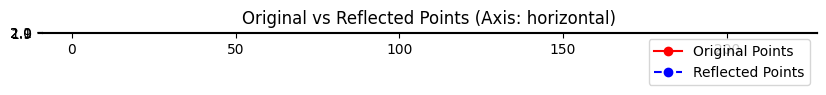

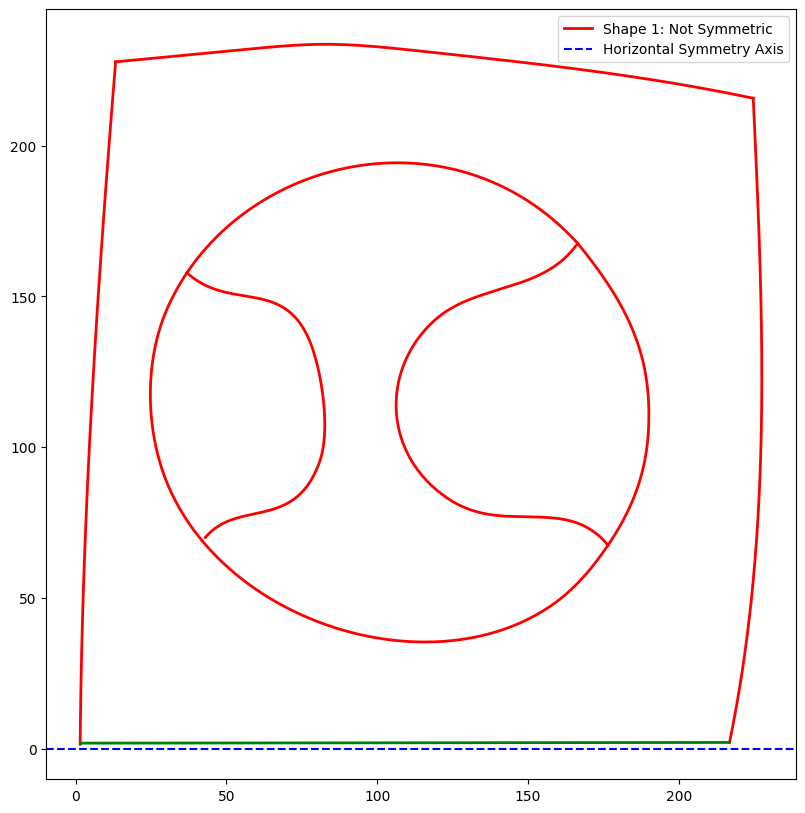

In [15]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt

# ## Paths
# Define the paths for the zip file, extracted folder, input CSV file, and output folder.
zip_path = '/content/drive/MyDrive/adobezip.zip'
extracted_path = '/mnt/data/extracted'
input_file_path = '/mnt/data/extracted/problems/frag0.csv'
output_folder = '/mnt/data/extracted/output'

# ## Extract the zip file
# Extract all contents from the zip file to the specified `extracted_path`.
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# ## Ensure output folder exists
# Create the output directory if it doesn't exist.
os.makedirs(output_folder, exist_ok=True)

# ## Symmetry Detection Functions
# Define functions to reflect points, check symmetry, plot results, and process the CSV file.

def reflect_points(points, axis):
    if axis == 'horizontal':
        return np.array([[x, 2 * np.mean(points[:, 1]) - y] for x, y in points])
    elif axis == 'vertical':
        return np.array([[2 * np.mean(points[:, 0]) - x, y] for x, y in points])
    elif axis == 'diagonal1':  # y = x
        return np.array([[y, x] for x, y in points])
    elif axis == 'diagonal2':  # y = -x
        return np.array([[-y, -x] for x, y in points])

def is_symmetric(points, axis, threshold=0.5):
    reflected_points = reflect_points(points, axis)
    distances = np.zeros(len(points))
    for i, point in enumerate(points):
        closest_distance = np.min(np.linalg.norm(reflected_points - point, axis=1))
        distances[i] = closest_distance
    matching_points = np.sum(distances <= threshold)
    symmetry_score = matching_points / len(points)
    return symmetry_score >= 0.75, symmetry_score

def check_symmetry(shape, threshold=0.5):
    best_score = 0
    best_axis = None
    for axis in ['horizontal', 'vertical', 'diagonal1', 'diagonal2']:
        symmetric, score = is_symmetric(shape, axis, threshold)
        if symmetric and score > best_score:
            best_score = score
            best_axis = axis
    return best_axis is not None, best_axis

def plot_reflection(points, axis, output_image):
    reflected_points = reflect_points(points, axis)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(points[:, 0], points[:, 1], 'ro-', label='Original Points')
    ax.plot(reflected_points[:, 0], reflected_points[:, 1], 'bo--', label='Reflected Points')
    ax.set_title(f'Original vs Reflected Points (Axis: {axis})')
    ax.legend()
    ax.set_aspect('equal')
    plt.savefig(output_image)
    plt.show()

def plot_shapes(shapes, results, output_image):
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = ['blue', 'green', 'red', 'orange']
    axes_labels = {'horizontal': 'Horizontal Axis', 'vertical': 'Vertical Axis',
                   'diagonal1': 'Diagonal (y=x) Axis', 'diagonal2': 'Diagonal (y=-x) Axis'}
    for i, (shape, result) in enumerate(zip(shapes, results)):
        color = 'green' if result[0] else 'red'
        label = f'Shape {i+1}: {"Symmetric" if result[0] else "Not Symmetric"} (Axis: {axes_labels[result[1]]})' if result[0] else f'Shape {i+1}: Not Symmetric'
        for path in shape:
            ax.plot(path[:, 0], path[:, 1], color=color, linewidth=2, label=label if i == 0 else "")
            if result[0]:
                if result[1] == 'horizontal':
                    ax.axhline(y=0, color='blue', linestyle='--', label='Horizontal Symmetry Axis')
                elif result[1] == 'vertical':
                    ax.axvline(x=0, color='blue', linestyle='--', label='Vertical Symmetry Axis')
                elif result[1] == 'diagonal1':
                    ax.plot([-10, 10], [-10, 10], color='blue', linestyle='--', label='Diagonal (y=x) Symmetry Axis')
                elif result[1] == 'diagonal2':
                    ax.plot([-10, 10], [10, -10], color='blue', linestyle='--', label='Diagonal (y=-x) Symmetry Axis')
    ax.legend()
    ax.set_aspect('equal')
    os.makedirs(os.path.dirname(output_image), exist_ok=True)
    plt.savefig(output_image)
    plt.show()

def main(input_csv, output_image, reflection_image, threshold=0.5):
    shapes = read_csv(input_csv)
    results = []
    for shape_idx, shape in enumerate(shapes, start=1):
        shape_is_symmetric = False
        axis_of_symmetry = None
        for path in shape:
            result = check_symmetry(path, threshold)
            if result[0]:
                shape_is_symmetric = True
                axis_of_symmetry = result[1]
                results.append(result)
                break
        if shape_is_symmetric:
            plot_reflection(path, axis_of_symmetry, reflection_image)
        else:
            results.append((False, None))
    plot_shapes(shapes, results, output_image)

# ## Example Usage
# Run the symmetry detection on the extracted file.
output_image = os.path.join(output_folder, 'refined_output.png')
reflection_image = os.path.join(output_folder, 'refined_reflection.png')

main(input_file_path, output_image, reflection_image, threshold=0.5)
